<a href="https://colab.research.google.com/github/adminsolvve/ml_course/blob/master/face_identification_ORL_simple_classification_with_normalization_and_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import cv2
import fnmatch
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [102]:
#retrieving the dataset
!git clone https://github.com/SilvesterHsu/ORLFaceRecognition-PCA.git

fatal: destination path 'ORLFaceRecognition-PCA' already exists and is not an empty directory.


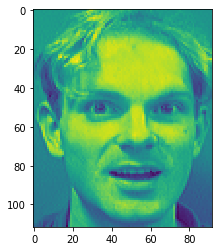

In [103]:
#the size of the images in the dataset
height = 112 
width = 92
columns=height*width

#uploading all the image files to the numpy array, 
#saving the human index,
#and the sequence number of the photo for each person.
arr = np.empty((0, columns + 2), int)
for i in os.walk(os.path.join('ORLFaceRecognition-PCA','att_faces')):
  address, dirs, files = i[0], i[1], i[2]
  person = address.split('/')[-1][1:]
  for filename in fnmatch.filter(files, '*.pgm'):
    f_index = str(filename.split('.')[0]).zfill(2)
    img_path = os.path.join(address,filename)
    img = cv2.imread(os.path.join(address,filename))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    r_gray = gray.reshape(1, height * width)
    r_gray = np.insert(r_gray, 0, person)
    r_gray = np.insert(r_gray, 0, f_index)
    arr = np.vstack((arr, r_gray))

#sorting data from photos to ensure repeatability of the script.
arr = arr[arr[:,0].argsort()]
arr = arr[arr[:,1].argsort(kind='mergesort')]
#deletion of the unnecessary photo index number for each person.
arr = np.delete(arr, np.s_[0:1], axis=1)
#data set section: index and photo
Y = np.delete(arr, np.s_[1:], axis=1)
X = np.delete(arr, np.s_[0:1], axis=1)
plt.imshow(gray)


In [104]:
def split_dataset_shuffle(X, Y, train_percent = 80, random_state = 1, stratify = Y):
  '''dividing the dataset into training and test parts.'''
  train_percent = train_percent /100
  return train_test_split(
        X,
        Y,
        random_state = random_state,
        train_size = train_percent,
        shuffle = True,
        stratify = stratify,
    )
X_train, X_test, Y_train, Y_test = split_dataset_shuffle(X, Y, train_percent = 10)
print(X_train.shape, X_test.shape)
print(X_train[1].shape, X_test[1].shape)

(40, 10304) (360, 10304)
(10304,) (10304,)


In [0]:
def my_mse(X_train, X_test):
    '''implementation of mse'''
    result = np.square(X_train - X_test).mean(axis=1)
    return result

In [0]:
def my_msa(X_train, X_test):
    '''implementation of mse'''
    result = np.absolute(X_train - X_test).mean(axis=1)
    return result

In [0]:
class MyNormalise(TransformerMixin, BaseEstimator):
    '''Get the maximum values of each column i.e. along axis 0'''

    def __init__(self, norm_axis = 0, use = False):
        self.norm_axis = norm_axis
        self.use = use

    def fit(self, X, y = None):
        if self.use:
            self.norm_max = np.amax(X, axis = self.norm_axis)
            self.norm_min = np.amin(X, axis = self.norm_axis)
            self.norm_difminmax = self.norm_max - self.norm_min
        return self

    def transform(self, X):
        if self.use:
            if self.norm_axis == 0:
                X = (X - self.norm_min) / self.norm_difminmax
            else:
                self.norm_max = np.amax(X, axis = self.norm_axis)
                self.norm_min = np.amin(X, axis = self.norm_axis)
                self.norm_difminmax = self.norm_max - self.norm_min
                X = ((X.T - self.norm_min) / self.norm_difminmax).T
        return X

class MyPredict(TransformerMixin, BaseEstimator):
    '''A predictor.'''

    def __init__(self, my_method):
        self.my_method = my_method
        pass

    def fit(self, X, y = None):
        self.X_train = X
        self.Y_train = y
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        Y_pred =[]
        for i in range (0, X.shape[0]):
          Y_current =self.Y_train[(self.my_method(self.X_train, X[i]).argmin())][0]
          Y_pred.append(Y_current)
        Y_pred = np.array(Y_pred)
        Y_pred = Y_pred.reshape(Y_pred.shape[0],1)
        return Y_pred

In [0]:
def get_compare(Y_test, Y_pred):
  compare = Y_test == Y_pred
  return compare
def get_accuracy(acc):
  return acc.sum()/acc.shape[0]

In [0]:
def predicts_randoms(
    train_percent_min = 0,
    train_percent_max = 9,
    stratify = True,
    X = X,
    Y = Y,
    use_norm = False,
    norm_axis = 0,
    method = my_mse):
    ''' '''
    results = pd.DataFrame(columns = ['train', 
                                      'random_state', 
                                      'accuracy'])
    print('train', 'random_state')
    for train_percent in range(train_percent_min, train_percent_max):
        print(train_percent + 1, ' ', end = '')
        for random_state in range(20):
            print(random_state, end = '')
            strat = Y if stratify else None 
            pipe = Pipeline([  
                ('MyNormalise', MyNormalise(use = use_norm, norm_axis = norm_axis)),
                ('MyPredict', MyPredict(method)),
                ])
            X_train, X_test, Y_train, Y_test = split_dataset_shuffle(
              X, 
              Y, 
              train_percent = (train_percent + 1) * 10, 
              random_state = random_state, 
              stratify = strat)
            pipe.fit(X_train, Y_train)
            Y_pred = pipe.predict(X_test)
            compare = get_compare(Y_test, Y_pred)
            accuracy = round(get_accuracy(compare), 4)
            results =results.append(
                {   'train' : (train_percent+1)*10, 
                    'random_state' : random_state,  
                    'accuracy' : accuracy}, 
                ignore_index=True)
        print()
    print()
    return pd.pivot_table(results, values='accuracy', index=['train'], columns=['random_state'])




train random_state
1  012345678910111213141516171819
2  012345678910111213141516171819
3  012345678910111213141516171819
4  012345678910111213141516171819
5  012345678910111213141516171819
6  012345678910111213141516171819
7  012345678910111213141516171819
8  012345678910111213141516171819
9  012345678910111213141516171819



random_state,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
train,,,,,,,,,,,,,,,,,,,,
10.0,0.4083,0.4833,0.4583,0.4611,0.4639,0.4778,0.4944,0.4722,0.4611,0.4278,0.4500,0.4694,0.4444,0.4389,0.4528,0.4833,0.4361,0.4667,0.4917,0.4028
20.0,0.6562,0.7000,0.6094,0.6812,0.7188,0.7219,0.7219,0.7219,0.7219,0.5969,0.6906,0.6000,0.6750,0.6094,0.7062,0.6562,0.6688,0.7156,0.6625,0.6500
30.0,0.7536,0.8357,0.8179,0.8036,0.8000,0.7964,0.8179,0.8536,0.8643,0.7679,0.8071,0.7750,0.7357,0.7250,0.7786,0.8536,0.8321,0.8429,0.7464,0.7750
40.0,0.8708,0.8792,0.8625,0.9042,0.8292,0.9167,0.8917,0.9208,0.9125,0.8125,0.8792,0.8542,0.8583,0.7708,0.8208,0.8917,0.9625,0.8750,0.7542,0.8500
50.0,0.9450,0.9100,0.9250,0.9450,0.8900,0.9200,0.9200,0.9450,0.9350,0.9350,0.9200,0.8750,0.8800,0.9100,0.9100,0.9550,0.9700,0.8900,0.8300,0.8850
60.0,0.9562,0.9125,0.9500,0.9375,0.9250,0.9375,0.9438,0.9375,0.9438,0.9500,0.9500,0.8750,0.9375,0.9562,0.9375,0.9625,0.9812,0.9000,0.9125,0.8938
70.0,0.9583,0.9333,0.9583,0.9500,0.9583,0.9417,0.9500,0.9667,0.9333,0.9583,0.9583,0.8917,0.9667,0.9583,0.9667,0.9750,0.9750,0.9500,0.9333,0.9500
80.0,0.9750,0.9375,0.9625,0.9875,0.9875,0.9375,0.9750,0.9875,0.9875,0.9500,0.9750,0.9375,0.9625,0.9625,0.9750,0.9625,0.9750,0.9750,0.9625,0.9625
90.0,0.9750,0.9750,0.9750,1.0000,0.9750,0.9500,1.0000,0.9750,0.9750,0.9500,1.0000,0.9750,0.9750,0.9750,0.9750,0.9750,1.0000,0.9750,0.9750,0.9500


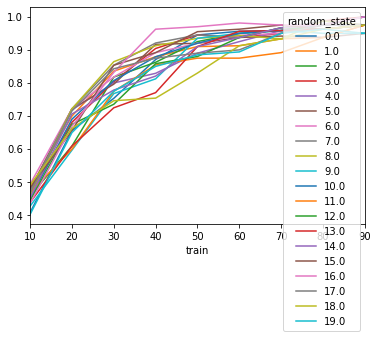

In [111]:
predicted = predicts_randoms(stratify = False)
predicted.plot(figsize=(12,12))
predicted

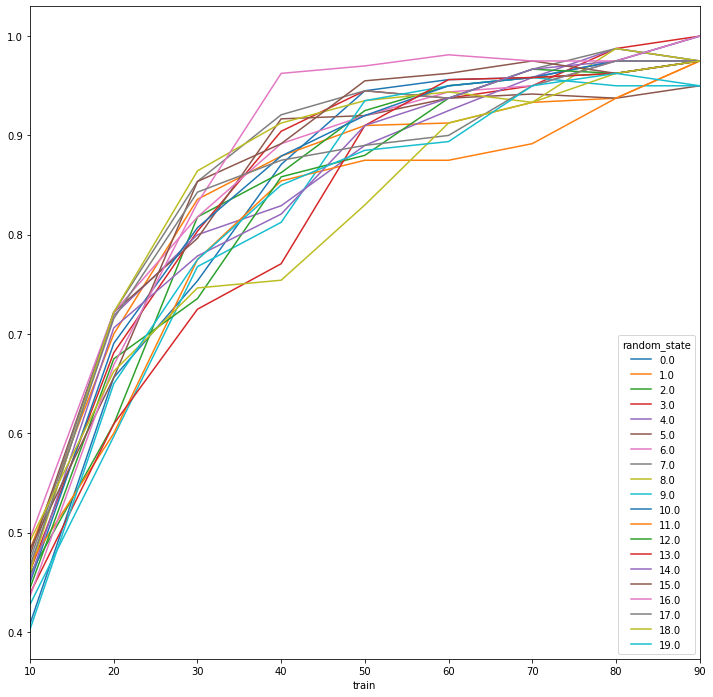

In [124]:
predicted.plot(figsize=(12,12))

In [0]:
def results_average(results_randoms):
    return  round(results_randoms.mean(1), 4)

In [0]:
def add_column(df, colname, arr):
    df[colname] = pd.DataFrame(arr).loc[:,0]
    df.plot(figsize=(12,12))
    return df


,mse_nostrat
train,
10.0,0.4572
20.0,0.6742
30.0,0.7991
40.0,0.8658
50.0,0.9148
60.0,0.9350
70.0,0.9517
80.0,0.9669
90.0,0.9762


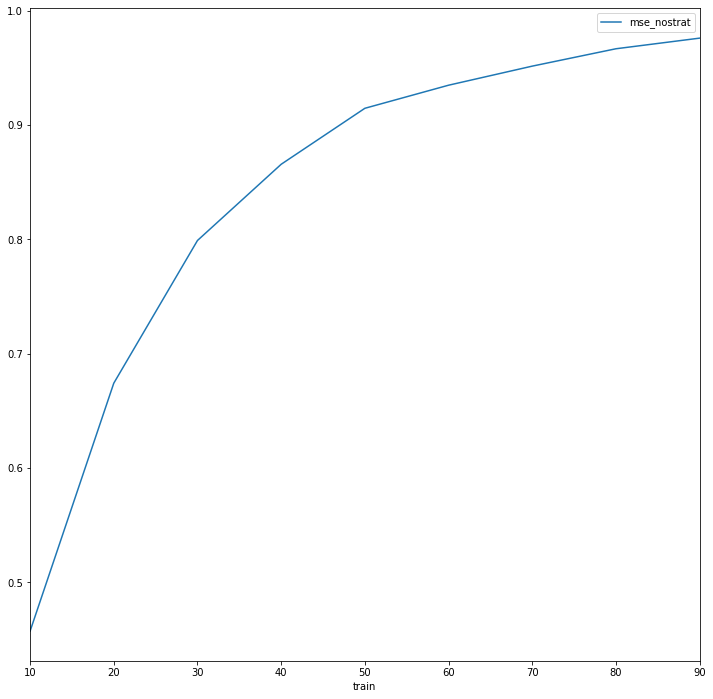

In [114]:
results = pd.DataFrame()
results = add_column(results, "mse_nostrat", results_average(predicted))
results

train random_state
1  012345678910111213141516171819
2  012345678910111213141516171819
3  012345678910111213141516171819
4  012345678910111213141516171819
5  012345678910111213141516171819
6  012345678910111213141516171819
7  012345678910111213141516171819
8  012345678910111213141516171819
9  012345678910111213141516171819



,mse_nostrat,mse_strat
train,,
10.0,0.4572,0.6810
20.0,0.6742,0.8105
30.0,0.7991,0.8725
40.0,0.8658,0.9194
50.0,0.9148,0.9503
60.0,0.9350,0.9653
70.0,0.9517,0.9712
80.0,0.9669,0.9750
90.0,0.9762,0.9788


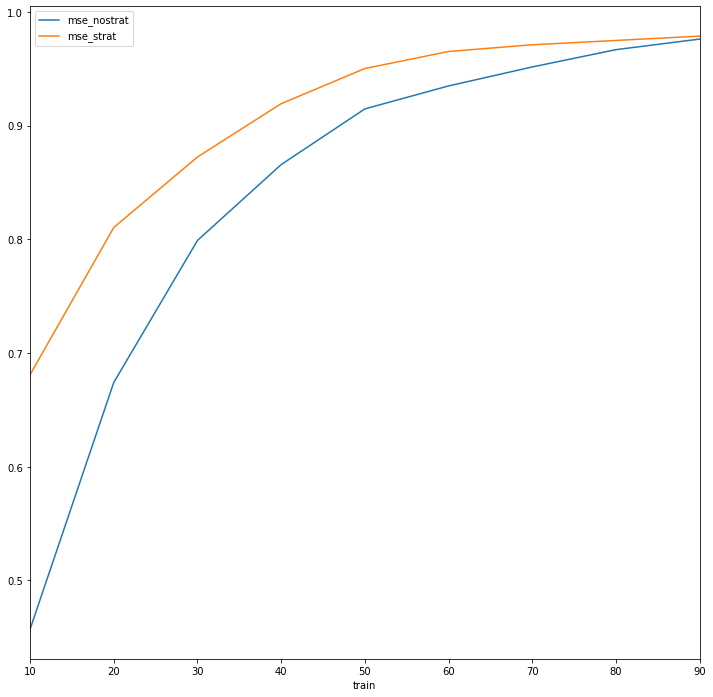

In [115]:
results = add_column(results, "mse_strat", results_average(predicts_randoms(stratify = True)))
results

train random_state
1  012345678910111213141516171819
2  012345678910111213141516171819
3  012345678910111213141516171819
4  012345678910111213141516171819
5  012345678910111213141516171819
6  012345678910111213141516171819
7  012345678910111213141516171819
8  012345678910111213141516171819
9  012345678910111213141516171819



,mse_nostrat,mse_strat,msa_strat
train,,,
10.0,0.4572,0.6810,0.7226
20.0,0.6742,0.8105,0.8394
30.0,0.7991,0.8725,0.8989
40.0,0.8658,0.9194,0.9413
50.0,0.9148,0.9503,0.9710
60.0,0.9350,0.9653,0.9788
70.0,0.9517,0.9712,0.9825
80.0,0.9669,0.9750,0.9825
90.0,0.9762,0.9788,0.9913


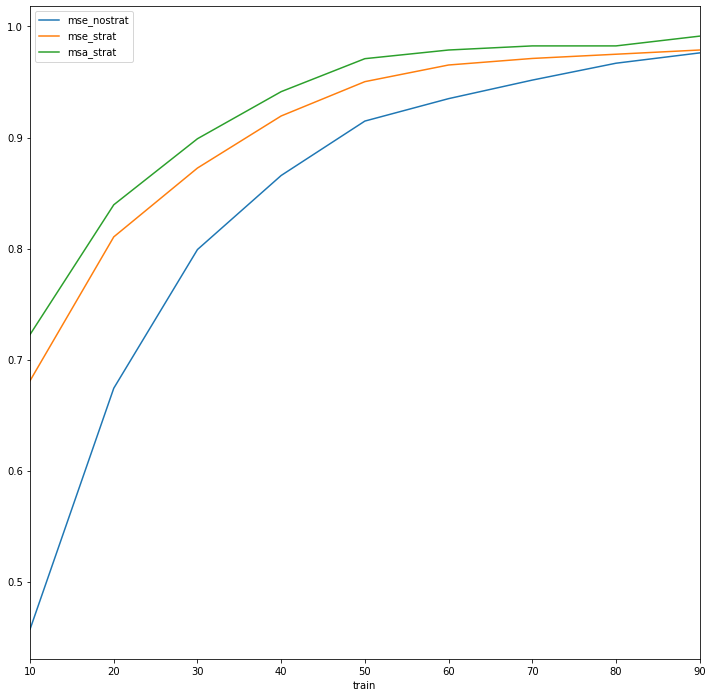

In [116]:
results = add_column(results, "msa_strat", results_average(predicts_randoms(method = my_msa, stratify = True)))
results

train random_state
1  012345678910111213141516171819
2  012345678910111213141516171819
3  012345678910111213141516171819
4  012345678910111213141516171819
5  012345678910111213141516171819
6  012345678910111213141516171819
7  012345678910111213141516171819
8  012345678910111213141516171819
9  012345678910111213141516171819



,mse_nostrat,mse_strat,msa_strat,mse_strat_normc
train,,,,
10.0,0.4572,0.6810,0.7226,0.6753
20.0,0.6742,0.8105,0.8394,0.8072
30.0,0.7991,0.8725,0.8989,0.8707
40.0,0.8658,0.9194,0.9413,0.9190
50.0,0.9148,0.9503,0.9710,0.9525
60.0,0.9350,0.9653,0.9788,0.9672
70.0,0.9517,0.9712,0.9825,0.9717
80.0,0.9669,0.9750,0.9825,0.9756
90.0,0.9762,0.9788,0.9913,0.9800


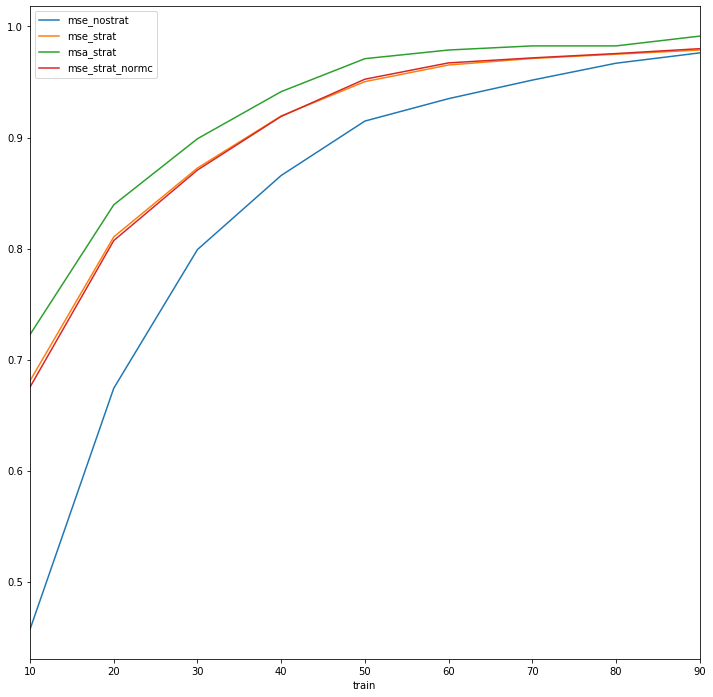

In [117]:
results = add_column(results, "mse_strat_normc", results_average(
    predicts_randoms(method = my_mse, 
                     stratify = True, 
                     use_norm = True,  
                     norm_axis = 0)))
results

train random_state
1  012345678910111213141516171819
2  012345678910111213141516171819
3  012345678910111213141516171819
4  012345678910111213141516171819
5  012345678910111213141516171819
6  012345678910111213141516171819
7  012345678910111213141516171819
8  012345678910111213141516171819
9  012345678910111213141516171819



,mse_nostrat,mse_strat,msa_strat,mse_strat_normc,mse_strat_normr
train,,,,,
10.0,0.4572,0.6810,0.7226,0.6753,0.6690
20.0,0.6742,0.8105,0.8394,0.8072,0.8056
30.0,0.7991,0.8725,0.8989,0.8707,0.8639
40.0,0.8658,0.9194,0.9413,0.9190,0.9127
50.0,0.9148,0.9503,0.9710,0.9525,0.9445
60.0,0.9350,0.9653,0.9788,0.9672,0.9600
70.0,0.9517,0.9712,0.9825,0.9717,0.9625
80.0,0.9669,0.9750,0.9825,0.9756,0.9663
90.0,0.9762,0.9788,0.9913,0.9800,0.9725


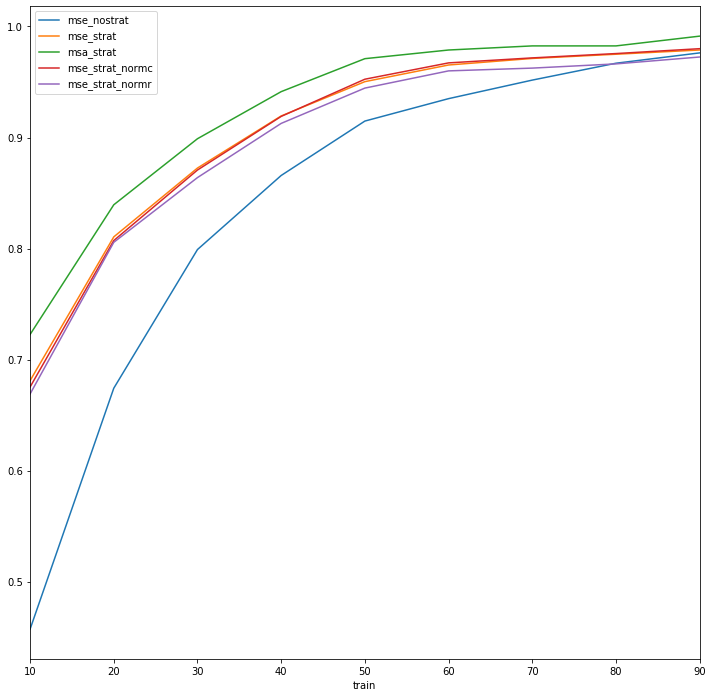

In [118]:
results = add_column(results, "mse_strat_normr", results_average(
    predicts_randoms(method = my_mse, 
                     stratify = True, 
                     use_norm = True,  
                     norm_axis = 1)))
results

train random_state
1  012345678910111213141516171819
2  012345678910111213141516171819
3  012345678910111213141516171819
4  012345678910111213141516171819
5  012345678910111213141516171819
6  012345678910111213141516171819
7  012345678910111213141516171819
8  012345678910111213141516171819
9  012345678910111213141516171819



,mse_nostrat,mse_strat,msa_strat,mse_strat_normc,mse_strat_normr,msa_strat_normc
train,,,,,,
10.0,0.4572,0.6810,0.7226,0.6753,0.6690,0.7214
20.0,0.6742,0.8105,0.8394,0.8072,0.8056,0.8394
30.0,0.7991,0.8725,0.8989,0.8707,0.8639,0.8986
40.0,0.8658,0.9194,0.9413,0.9190,0.9127,0.9415
50.0,0.9148,0.9503,0.9710,0.9525,0.9445,0.9710
60.0,0.9350,0.9653,0.9788,0.9672,0.9600,0.9788
70.0,0.9517,0.9712,0.9825,0.9717,0.9625,0.9817
80.0,0.9669,0.9750,0.9825,0.9756,0.9663,0.9825
90.0,0.9762,0.9788,0.9913,0.9800,0.9725,0.9900


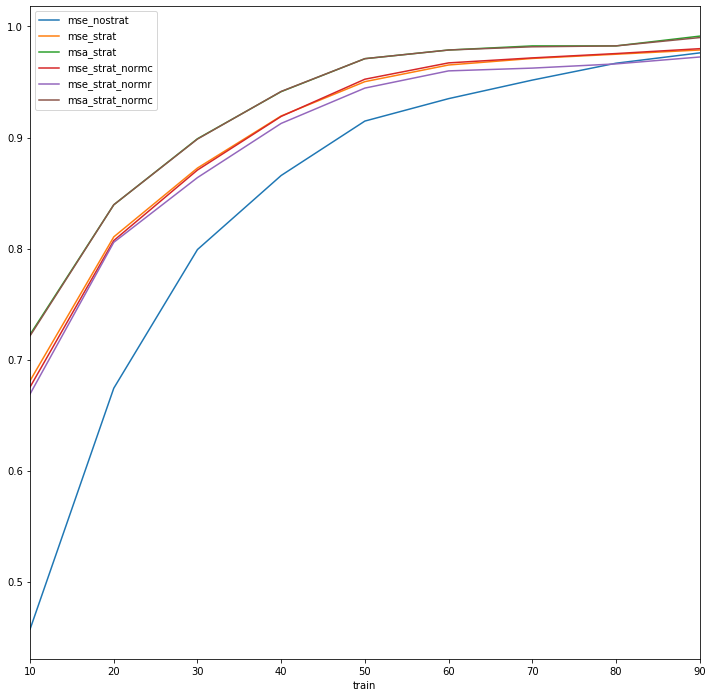

In [119]:
results = add_column(results, "msa_strat_normc", results_average(
    predicts_randoms(method = my_msa, 
                     stratify = True, 
                     use_norm = True,  
                     norm_axis = 0)))
results

train random_state
1  012345678910111213141516171819
2  012345678910111213141516171819
3  012345678910111213141516171819
4  012345678910111213141516171819
5  012345678910111213141516171819
6  012345678910111213141516171819
7  012345678910111213141516171819
8  012345678910111213141516171819
9  012345678910111213141516171819



,mse_nostrat,mse_strat,msa_strat,mse_strat_normc,mse_strat_normr,msa_strat_normc,msa_strat_normr
train,,,,,,,
10.0,0.4572,0.6810,0.7226,0.6753,0.6690,0.7214,0.6951
20.0,0.6742,0.8105,0.8394,0.8072,0.8056,0.8394,0.8252
30.0,0.7991,0.8725,0.8989,0.8707,0.8639,0.8986,0.8818
40.0,0.8658,0.9194,0.9413,0.9190,0.9127,0.9415,0.9296
50.0,0.9148,0.9503,0.9710,0.9525,0.9445,0.9710,0.9592
60.0,0.9350,0.9653,0.9788,0.9672,0.9600,0.9788,0.9725
70.0,0.9517,0.9712,0.9825,0.9717,0.9625,0.9817,0.9758
80.0,0.9669,0.9750,0.9825,0.9756,0.9663,0.9825,0.9788
90.0,0.9762,0.9788,0.9913,0.9800,0.9725,0.9900,0.9850


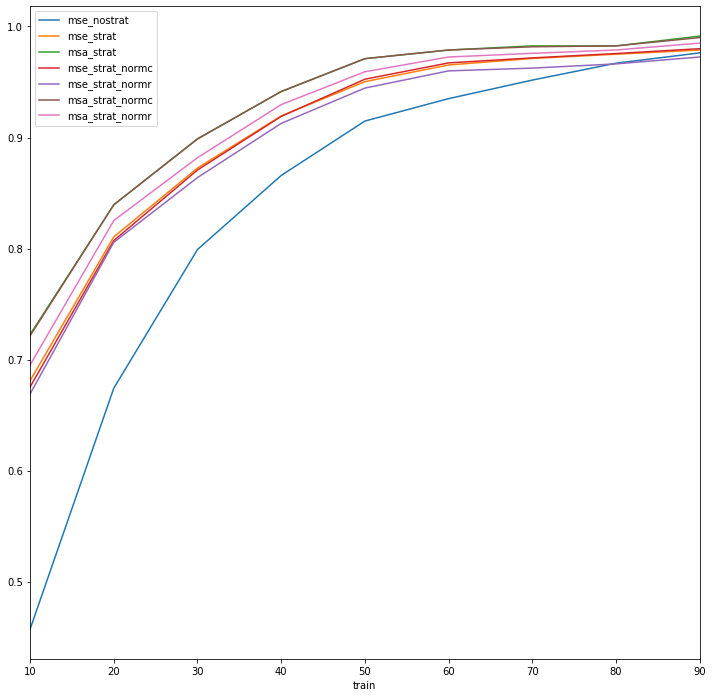

In [120]:
results = add_column(results, "msa_strat_normr", results_average(
    predicts_randoms(method = my_msa, 
                     stratify = True, 
                     use_norm = True,  
                     norm_axis = 1)))
results

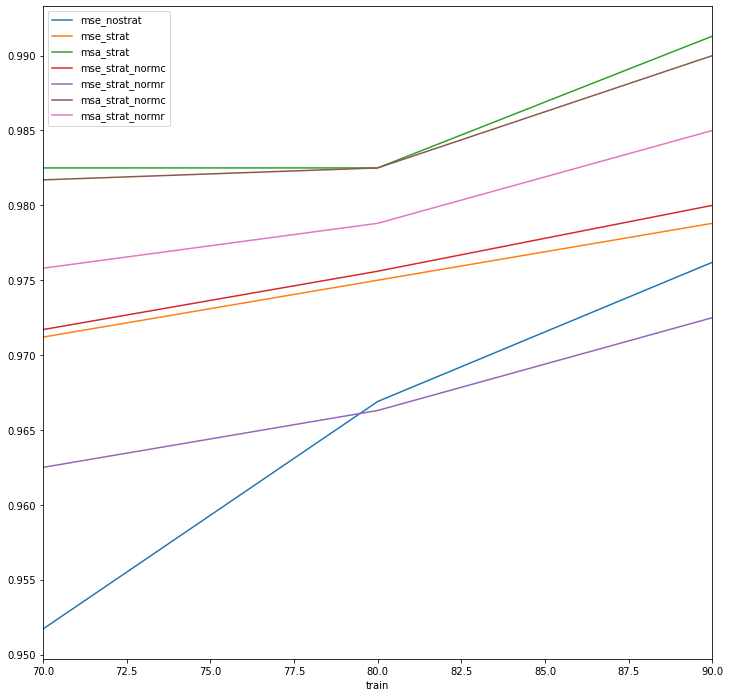

In [123]:
results.iloc[6:,:].plot(figsize=(12,12))

In [122]:
results

,mse_nostrat,mse_strat,msa_strat,mse_strat_normc,mse_strat_normr,msa_strat_normc,msa_strat_normr
train,,,,,,,
10.0,0.4572,0.6810,0.7226,0.6753,0.6690,0.7214,0.6951
20.0,0.6742,0.8105,0.8394,0.8072,0.8056,0.8394,0.8252
30.0,0.7991,0.8725,0.8989,0.8707,0.8639,0.8986,0.8818
40.0,0.8658,0.9194,0.9413,0.9190,0.9127,0.9415,0.9296
50.0,0.9148,0.9503,0.9710,0.9525,0.9445,0.9710,0.9592
60.0,0.9350,0.9653,0.9788,0.9672,0.9600,0.9788,0.9725
70.0,0.9517,0.9712,0.9825,0.9717,0.9625,0.9817,0.9758
80.0,0.9669,0.9750,0.9825,0.9756,0.9663,0.9825,0.9788
90.0,0.9762,0.9788,0.9913,0.9800,0.9725,0.9900,0.9850
